In [1]:
import os
import sys
import random
import json
import collections
import itertools

import pandas as pd
import numpy as np
import scipy        
import statsmodels


from tqdm import trange, tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

pd.options.display.max_columns = 999

sns.set()

plt.rcParams["figure.figsize"] = (10,7)

In [2]:
os.getcwd()

'/home/boris/study/UT study/ACM Sigmod/sigmod/notebooks'

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from sigmod_src.utils import read_json, pprint_json, path_from_spec_id, get_vector_for_spec_id
from sigmod_src.data.embedding import Embedder

# Load data

In [6]:
LABELS_PATH = '../data/raw/sigmod_medium_labelled_dataset.csv'

In [7]:
labels_df = pd.read_csv(LABELS_PATH)
labels_df.shape

(46665, 3)

In [8]:
labels_df.head()

,left_spec_id,right_spec_id,label
0,www.garricks.com.au//31,www.ebay.com//53278,1
1,www.ebay.com//58782,www.ebay.com//24817,0
2,www.ebay.com//58782,www.ebay.com//43019,0
3,www.ebay.com//42055,www.ebay.com//54403,0
4,www.ebay.com//44280,buy.net//6145,0


# Load specs df

In [9]:
specs_df = pd.read_csv('../data/processed/specs_preprocessed.csv')
specs_df.index=  specs_df.spec_id
specs_df.shape

(29771, 5)

In [10]:
specs_df[specs_df.page_title.isnull()]

,spec_id,page_title,page_title_stem,brand,site
spec_id,,,,,


In [11]:
specs_df.head()

,spec_id,page_title,page_title_stem,brand,site
spec_id,,,,,
www.ebay.com//57656,www.ebay.com//57656,canon powershot elph 110 hs 16 1 mp,canon powershot elph 110 hs 16 1 mp,canon,www.ebay.com
www.ebay.com//60583,www.ebay.com//60583,canon rebel 2000 35 mm great condition case,canon rebel 2000 35 mm great condit case,canon,www.ebay.com
www.ebay.com//60440,www.ebay.com//60440,canon eos rebel t3i 18 55mm,canon eo rebel t3i 18 55mm,canon,www.ebay.com
www.ebay.com//24139,www.ebay.com//24139,ge c1033 10 1 mp 3x zoom 2,ge c1033 10 1 mp 3x zoom 2,ge,www.ebay.com
www.ebay.com//54903,www.ebay.com//54903,vivitar clip shot 1 1 mp,vivitar clip shot 1 1 mp,vivitar,www.ebay.com


In [12]:
specs_df.page_title.sample(5).values[0]

'olympus e 510 10 0 mp 14 45mm'

In [13]:
specs_df.page_title_stem.sample(5).values[0]

'onvif hd cmos manual zoom len dome p2p case'

# Make embedder and index

In [14]:
# emb = Embedder.load('../models/embedder')

In [24]:
emb = Embedder(vector_size=200,
               train_epochs=100,
               index_trees=1000)

In [25]:
emb.fit(specs_df.page_title_stem, specs_df.spec_id)

Epoch #10
Epoch #20
Epoch #30
Epoch #40
Epoch #50
Epoch #60
Epoch #70
Epoch #80
Epoch #90
Epoch #100


/home/boris/anaconda3/lib/python3.6/site-packages/gensim/similarities/index.py:184: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  index = AnnoyIndex(num_features)


# Visual evaluation

In [26]:
random_spec = specs_df.sample(1).iloc[0]
spec_id = random_spec.spec_id
text = random_spec.page_title_stem

nn_ids = emb.lookup_ids(text, n=100)
nn_texts = specs_df.page_title_stem.loc[nn_ids].values

print(f'Query:\n\t{text}')
newline_ = '\n\t'
print(f'3 Closest:\n\t{newline_.join(nn_texts[:3])}')

print(f'Most distant:\n\t{nn_texts[-1]}')

Query:
	olympus zealand price
3 Closest:
	olympus zealand price
	olympus zealand price
	olympus zealand price pricem
Most distant:
	olympus mp


# Obtian labelled dataset recall

In [27]:
def get_candidate_specs(query_text, emb, n):
    nns = emb.lookup(query_text, n=n)
    nn_spec_ids = [nn[0] for nn in nns]
    return nn_spec_ids

dups_df = labels_df[labels_df.label==1]
results = []
for row in tqdm(dups_df.sample(int(0.5*len(dups_df))).itertuples()):
    left_spec = specs_df.loc[row.left_spec_id]
    candidates = emb.lookup_ids(left_spec.page_title_stem, n=1000)
    
    target_index = None
    if row.right_spec_id in candidates:
        target_index = candidates.index(row.right_spec_id)
    
    
    results.append((row.left_spec_id, row.right_spec_id, target_index))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [28]:
results_df = pd.DataFrame(results)
results_df.columns = ['left_spec_id', 'right_spec_id', 'right_spec_rank']
results_df.head()

,left_spec_id,right_spec_id,right_spec_rank
0,www.ebay.com//47932,www.ebay.com//41940,NaN
1,www.shopbot.com.au//331,www.ebay.com//52928,NaN
2,www.ebay.com//25180,www.ebay.com//54939,NaN
3,www.walmart.com//633,www.ebay.com//47932,NaN
4,www.ebay.com//43940,www.walmart.com//644,NaN


In [29]:
def compute_recall_k(ranks, k):
    total_number = len(ranks)
    matched_number = ranks[(~ranks.isnull()) & (ranks <= k)]
    return len(matched_number)/total_number

In [30]:
ks = [1, 10, 50, 100, 500, 1000]
for k in ks:
    print(f'Recall-{k}: ', round(compute_recall_k(results_df.right_spec_rank, k), 4))

Recall-1:  0.0017
Recall-10:  0.0089
Recall-50:  0.0201
Recall-100:  0.038
Recall-500:  0.1697
Recall-1000:  0.2552


# Visualize embedding

## Obtain classes from labels

Each class - camera model. All specs that are duplicates of eachother consitute the same class. In a graph one class = one connected component.

In [33]:
dup_df = labels_df[labels_df.label==1][['left_spec_id', 'right_spec_id', 'label']].sort_values(by=['left_spec_id', 'right_spec_id'])

In [34]:
dup_df.shape

(3582, 3)

In [35]:
dup_df.head()

,left_spec_id,right_spec_id,label
27484,buy.net//5641,www.ebay.com//58588,1
24490,buy.net//5641,www.gosale.com//849,1
12459,buy.net//5641,www.price-hunt.com//9794,1
5120,buy.net//5698,cammarkt.com//501,1
31627,buy.net//5698,www.ebay.com//41940,1


In [36]:
len(set(dup_df.left_spec_id).intersection(dup_df.right_spec_id))

252

In [37]:
class_mapping = {
    
}

def replace_class_mapping(prev_class, new_class):
    for k in class_mapping:
        if k == prev_class:
            class_mapping[k] = new_class

cur_class = 0
for row in dup_df.itertuples():
    if row.left_spec_id in class_mapping or row.right_spec_id in class_mapping:
        if row.left_spec_id in class_mapping and row.right_spec_id in class_mapping and class_mapping[row.left_spec_id] != class_mapping[row.right_spec_id]:
            raise Exception('wtf')
        
        existing_class = class_mapping.get(row.left_spec_id, class_mapping.get(row.right_spec_id))
        class_mapping[row.left_spec_id] = existing_class
        class_mapping[row.right_spec_id] = existing_class
    else:
        class_mapping[row.left_spec_id] = cur_class
        class_mapping[row.right_spec_id] = cur_class
        cur_class += 1


In [38]:
classes_df = pd.DataFrame({'spec_id': list(class_mapping.keys()), 'class_': list(class_mapping.values())})
classes_df.shape

(306, 2)

In [39]:
classes_df.head()

,spec_id,class_
0,buy.net//5641,0
1,www.ebay.com//58588,0
2,www.gosale.com//849,0
3,www.price-hunt.com//9794,0
4,buy.net//5698,1


In [104]:
classes_df.index = classes_df.spec_id

## Get spec vectors

In [50]:
vecs = emb.doc2vec.docvecs.vectors_docs

In [54]:
vecs.shape

(29771, 200)

In [65]:
vecs = pd.DataFrame(vecs, index=specs_df.spec_id)
vecs.shape

(29771, 200)

## Pairwise distances distirubtion

In [51]:
from scipy.spatial.distance import pdist, cdist

In [71]:
sample_features = vecs.sample(5000)

In [72]:
pairwise_distances = pdist(sample_features)

/home/boris/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


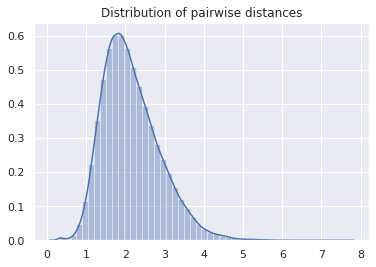

In [73]:
plt.figure()
plt.title('Distribution of pairwise distances')
sns.distplot(pairwise_distances)
plt.show()

In [74]:
# Vector for spec
vecs.loc['www.ebay.com//42835'].head()

0   -0.045119
1   -0.064009
2    0.136609
3    0.107015
4   -0.047888
Name: www.ebay.com//42835, dtype: float32

In [88]:
duplicate_pairs = dup_df.sample(1000)[['left_spec_id', 'right_spec_id']].values

duplicate_vector_pairs = []
for s1, s2 in duplicate_pairs:
    duplicate_vector_pairs.append([
        vecs.loc[s1],
        vecs.loc[s2]
    ])
    
duplicate_vector_pairs = np.array(duplicate_vector_pairs)

duplicate_vector_pairs[:3]

array([[[-0.17393182, -0.02544539,  0.16579558, ...,  0.06987065,
         -0.03432765,  0.03119265],
        [-0.00281865,  0.08442257,  0.04089072, ..., -0.10923864,
         -0.29468775,  0.0784305 ]],

       [[-0.03166717,  0.07730271,  0.02098622, ..., -0.01709495,
         -0.06661601,  0.08568059],
        [-0.00263251, -0.04840624,  0.09852695, ...,  0.09487066,
         -0.04286393, -0.07568391]],

       [[ 0.04665071, -0.01333624,  0.15095663, ...,  0.04686065,
         -0.10503448,  0.13103634],
        [-0.16161348, -0.02597628,  0.14134157, ...,  0.03348852,
         -0.05938867,  0.01785627]]], dtype=float32)

In [89]:
non_duplicate_pairs = labels_df[labels_df.label==0].sample(10000)[['left_spec_id', 'right_spec_id']].values

non_duplicate_vector_pairs = []
for s1, s2 in non_duplicate_pairs:
    non_duplicate_vector_pairs.append([
        vecs.loc[s1],
        vecs.loc[s2]
    ])

        
non_duplicate_vector_pairs = np.array(non_duplicate_vector_pairs)
non_duplicate_vector_pairs[:3]

array([[[-0.02518978, -0.054712  ,  0.18599375, ...,  0.07657019,
         -0.1622029 ,  0.02980449],
        [-0.04629386, -0.08941987, -0.01130236, ..., -0.00860991,
         -0.09799675,  0.03369134]],

       [[-0.11039374,  0.11573584,  0.16780064, ...,  0.2055268 ,
          0.04665672, -0.00941093],
        [-0.06202738, -0.05842616,  0.11538555, ...,  0.03862777,
         -0.09813445,  0.00707581]],

       [[ 0.02076366, -0.13753624,  0.15036097, ...,  0.03508536,
         -0.09003238, -0.0917429 ],
        [ 0.03426943, -0.01837048,  0.17242263, ...,  0.01447255,
         -0.24468581, -0.01284188]]], dtype=float32)

In [90]:
duplicate_vector_pairs.shape

(1000, 2, 200)

In [91]:
def compute_pairwise_distances(pairs_arr):
    dists = []
    for i in range(len(pairs_arr)):
        dists.append(pdist(pairs_arr[i])[0])
    return dists

In [92]:
duplicate_vector_pairs.shape

(1000, 2, 200)

In [93]:
duplicate_distances = compute_pairwise_distances(duplicate_vector_pairs)
non_duplicate_distances = compute_pairwise_distances(non_duplicate_vector_pairs)

In [94]:
len(duplicate_distances), len(non_duplicate_distances)

(1000, 10000)

/home/boris/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


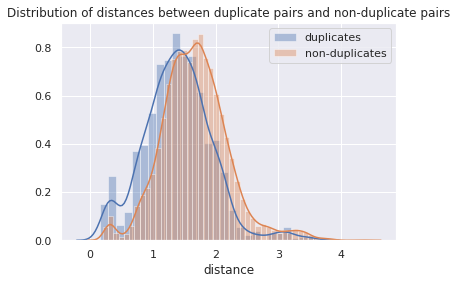

In [95]:
plt.figure()
plt.title('Distribution of distances between duplicate pairs and non-duplicate pairs')
sns.distplot(duplicate_distances, label='duplicates')
sns.distplot(non_duplicate_distances, label='non-duplicates')
plt.legend()
plt.xlabel('distance')
plt.show()

### Duplicates are more likely to have a small distance, but currenlty the embedding is crap

# TSNE visualization

In [96]:
from MulticoreTSNE import MulticoreTSNE as TSNE

In [97]:
tsne = TSNE(
    n_components=2,
    metric='cosine',
    n_jobs=3,
    verbose=True,
)

In [111]:
spec_features_ld = tsne.fit_transform(vecs)

In [112]:
spec_features_ld.shape

(29771, 2)

In [113]:
spec_features_ld = pd.DataFrame(spec_features_ld, index=specs_df.spec_id)
spec_features_ld['class_'] = classes_df.class_
spec_features_ld.shape

(29771, 3)

In [115]:
specs_df.iloc[46]

spec_id             www.ebay.com//41954
page_title         canon eos 20d 8 2 mp
page_title_stem     canon eo 20d 8 2 mp
brand                             canon
site                       www.ebay.com
Name: www.ebay.com//41954, dtype: object

In [116]:
spec_features_ld.iloc[46]

0         -7.045589
1         39.724914
class_     6.000000
Name: www.ebay.com//41954, dtype: float64

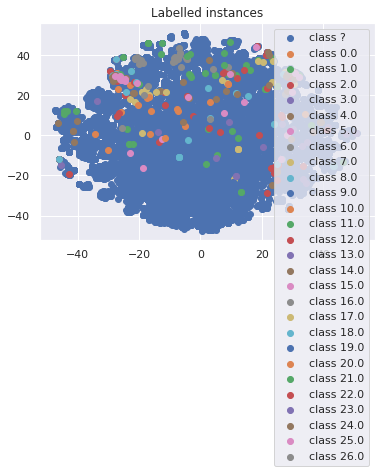

In [117]:
plt.figure()
plt.title('Labelled instances')
class_ld_df = spec_features_ld[pd.isnull(spec_features_ld.class_)]
plt.scatter(class_ld_df.iloc[:, 0], class_ld_df.iloc[:, 1], label=f'class ?')

for class_ in spec_features_ld['class_'].sort_values().unique():
    if pd.isnull(class_):
        continue
    class_ld_df = spec_features_ld[spec_features_ld.class_==class_]
    plt.scatter(class_ld_df.iloc[:, 0], class_ld_df.iloc[:, 1], label=f'class {class_}')

plt.legend()
plt.show()

## Either the embedding vectors are shit, or the visualization is shit